In [9]:
import os
import uproot
import numpy as np

root_folder = r"data/2"
filename = "test.root"
filepath = os.path.join(root_folder, filename)
file = uproot.open(filepath)
tree_name = "TBtree;1"
tree = file[tree_name]
df = tree.arrays(library="pd")
hit_index = df['hit_index'].to_list()
hit_q = df['hit_q'].to_list()
hit_issecondcoord = df['hit_issecondcoord'].to_list()
file.close()

num_strips = 360
test_events = []
for idxs, qs in zip(hit_index, hit_q):
    idxs = idxs[0]
    qs = qs[0]
    # Ricostruisci l'array di 360 strip
    charges = np.zeros(num_strips)
    for idx, q in zip(idxs, qs):
        charges[idx] = q
    test_events.append(charges)
test_events = np.array(test_events)
np.save(os.path.join(root_folder, "test"), test_events)

In [10]:
# Parametri
num_signal_events = 1000
num_strips = 360

signal_events = []
np.random.seed(42)

for _ in range(num_signal_events):
    # Centro del muone (posizione uniforme tra 0 e 359)
    mu = np.random.uniform(0, num_strips)
    # Carica massima (tra 900 e 1200)
    peak = np.random.uniform(900, 1200)
    # Numero di strip accese (tra 3 e 5)
    n_strips = np.random.randint(3, 6)
    # Trova gli indici delle strip accese, centrati su mu
    center = int(round(mu))
    half = n_strips // 2
    start = max(center - half, 0)
    end = min(center + half + 1, num_strips)
    strips_on = np.arange(start, end)
    # Distribuzione gaussiana solo sulle strip accese
    sigma = np.random.uniform(4, 10)
    charges = np.zeros(num_strips)
    for i in strips_on:
        charges[i] = peak * np.exp(-0.5 * ((i - mu) / sigma) ** 2)
    # Rumore elettronico solo sulle strip accese
    charges[strips_on] += np.random.normal(0, 5, size=len(strips_on))
    charges[charges < 0] = 0
    signal_events.append(charges)

signal_events = np.array(signal_events)

# --- Estrazione eventi di rumore dal file ROOT o caricamento da file ---
noise_events_path = os.path.join(root_folder, "noise_events.npy")
if os.path.exists(noise_events_path):
    noise_events = np.load(noise_events_path)
    print(f"Eventi di rumore caricati da file: {noise_events.shape[0]}")
else:
    import uproot
    noise_file = uproot.open(os.path.join(root_folder, "rumore.root"))
    noise_tree = noise_file["TBtree;1"]
    noise_df = noise_tree.arrays(library="pd")
    noise_hit_index = noise_df['hit_index'].to_list()
    noise_hit_q = noise_df['hit_q'].to_list()
    noise_file.close()

    noise_events = []
    for idxs, qs in zip(noise_hit_index, noise_hit_q):
        idxs = idxs[0]
        qs = qs[0]
        # Ricostruisci l'array di 360 strip
        charges = np.zeros(num_strips)
        for idx, q in zip(idxs, qs):
            charges[idx] = q
        noise_events.append(charges)
    noise_events = np.array(noise_events)
    np.save(noise_events_path, noise_events)
    print(f"Eventi di rumore estratti e salvati: {noise_events.shape[0]}")

print(f"Eventi di segnale generati: {signal_events.shape[0]}")
print(f"Eventi di rumore estratti: {noise_events.shape[0]}")

Eventi di rumore caricati da file: 8219
Eventi di segnale generati: 1000
Eventi di rumore estratti: 8219


Salvati: 8219 eventi X, 8219 eventi Y


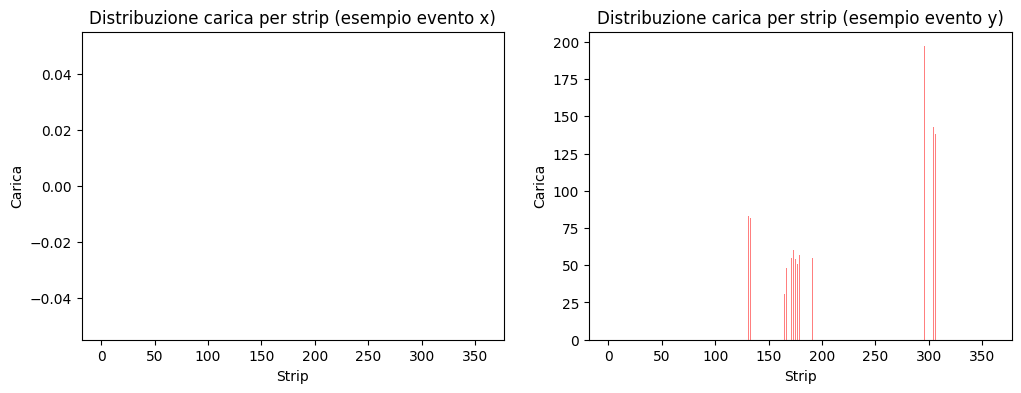

In [11]:
import uproot
import numpy as np
import os
import matplotlib.pyplot as plt

num_strips = 360

# Percorsi di salvataggio
noise_x_path = os.path.join(root_folder, "noise_x.npy")
noise_y_path = os.path.join(root_folder, "noise_y.npy")

noise_file = uproot.open(os.path.join(root_folder, "rumore.root"))
noise_tree = noise_file["TBtree;1"]
noise_df = noise_tree.arrays(library="pd")
noise_hit_index = noise_df['hit_index'].to_list()
noise_hit_q = noise_df['hit_q'].to_list()
noise_hit_issecondcoord = noise_df['hit_issecondcoord'].to_list()
noise_file.close()

# Separa per coordinata e salva come (indici, cariche)
xy_x = []
xy_y = []
for hit_index, hit_q, issecondcoord in zip(noise_hit_index, noise_hit_q, noise_hit_issecondcoord):
    for idxs, qs, isys in zip(hit_index, hit_q, issecondcoord):
        current_xy_x = np.zeros(num_strips)
        current_xy_y = np.zeros(num_strips)
        for idx, q, isy in zip(idxs, qs, isys):
            if isy == 0:
                current_xy_x[idx] = q
            else:
                current_xy_y[idx] = q
        xy_x.append(current_xy_x)
        xy_y.append(current_xy_y)

np.save(noise_x_path, np.array(xy_x, dtype=object))
np.save(noise_y_path, np.array(xy_y, dtype=object))
print(f"Salvati: {len(xy_x)} eventi X, {len(xy_y)} eventi Y")

n = 5

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(range(360), xy_x[n], color='blue', alpha=0.5)
plt.xlabel("Strip")
plt.ylabel("Carica")
plt.title("Distribuzione carica per strip (esempio evento x)")

plt.subplot(1, 2, 2)
plt.bar(range(360), xy_y[n], color='red', alpha=0.5)
plt.xlabel("Strip")
plt.ylabel("Carica")
plt.title("Distribuzione carica per strip (esempio evento y)")
plt.show()

Salvati: 6761 eventi X, 6761 eventi Y


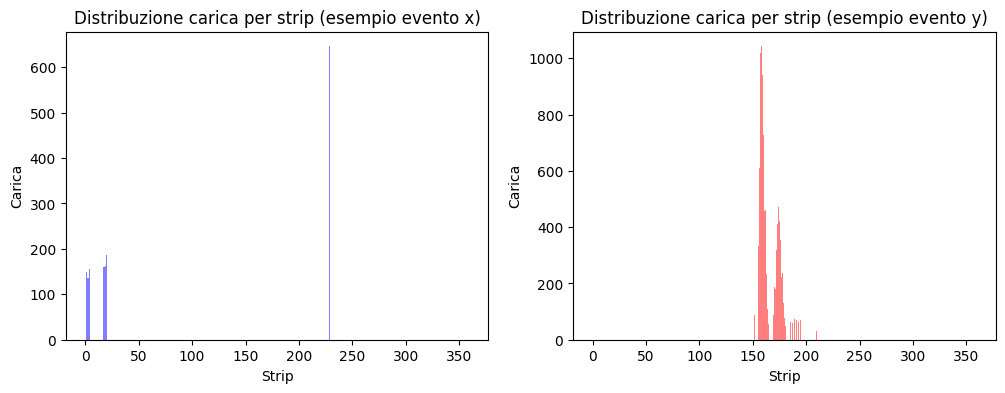

In [12]:
import uproot
import numpy as np
import os
import matplotlib.pyplot as plt

num_strips = 360

# Percorsi di salvataggio
noise_x_path = os.path.join(root_folder, "test_x.npy")
noise_y_path = os.path.join(root_folder, "test_y.npy")

noise_file = uproot.open(os.path.join(root_folder, "test.root"))
noise_tree = noise_file["TBtree;1"]
noise_df = noise_tree.arrays(library="pd")
noise_hit_index = noise_df['hit_index'].to_list()
noise_hit_q = noise_df['hit_q'].to_list()
noise_hit_issecondcoord = noise_df['hit_issecondcoord'].to_list()
noise_file.close()

# Separa per coordinata e salva come (indici, cariche)
xy_x = []
xy_y = []
for hit_index, hit_q, issecondcoord in zip(noise_hit_index, noise_hit_q, noise_hit_issecondcoord):
    for idxs, qs, isys in zip(hit_index, hit_q, issecondcoord):
        current_xy_x = np.zeros(num_strips)
        current_xy_y = np.zeros(num_strips)
        for idx, q, isy in zip(idxs, qs, isys):
            if isy == 0:
                current_xy_x[idx] = q
            else:
                current_xy_y[idx] = q
        xy_x.append(current_xy_x)
        xy_y.append(current_xy_y)

np.save(noise_x_path, np.array(xy_x, dtype=object))
np.save(noise_y_path, np.array(xy_y, dtype=object))
print(f"Salvati: {len(xy_x)} eventi X, {len(xy_y)} eventi Y")

n = 5

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(range(360), xy_x[n], color='blue', alpha=0.5)
plt.xlabel("Strip")
plt.ylabel("Carica")
plt.title("Distribuzione carica per strip (esempio evento x)")

plt.subplot(1, 2, 2)
plt.bar(range(360), xy_y[n], color='red', alpha=0.5)
plt.xlabel("Strip")
plt.ylabel("Carica")
plt.title("Distribuzione carica per strip (esempio evento y)")
plt.show()